In [ ]:
import os
import csv
import torch
import numpy as np
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ==== Hyperparameters and Paths ====
DATA_DIR = Path("./dataset")
MODEL_SAVE_DIR = Path("./models_customcnn")
MODEL_SAVE_DIR.mkdir(exist_ok=True)
IMG_SIZE = 224
BATCH_SIZE = 64
LR = 5e-4
EPOCHS = 10
NUM_WORKERS = 0 if os.name == 'nt' else 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ==== Dataset Setup ====
dirs = [d.name for d in DATA_DIR.iterdir() if d.is_dir()]
class_names = sorted(dirs)
num_classes = len(class_names)
print("Found classes:", class_names)

class BinaryFolderDataset(Dataset):
    def __init__(self, root_dir, positive_class, transform=None):
        self.transform = transform
        self.samples = []
        for cls_dir in Path(root_dir).iterdir():
            if not cls_dir.is_dir():
                continue
            label = 1 if cls_dir.name == positive_class else 0
            for ext in ("*.jpg", "*.jpeg", "*.png"):
                for img_path in cls_dir.glob(ext):
                    self.samples.append((img_path, label))
        if not self.samples:
            raise RuntimeError(f"No images found for class '{positive_class}' in {root_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

# ==== Transforms ====
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# ==== Custom Lightweight CNN ====
class SpeedCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(SpeedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),  # 112x112
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),  # 56x56
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),  # 28x28
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2)  # 14x14
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x  # shape [B, 1]

class SpeedCNN_v2(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.blocks = nn.Sequential(
            DepthwiseSeparableConv(16, 32), nn.MaxPool2d(2),  # 112x112
            DepthwiseSeparableConv(32, 64), nn.MaxPool2d(2),  # 56x56
            DepthwiseSeparableConv(64, 128), SEBlock(128), nn.MaxPool2d(2),  # 28x28
            DepthwiseSeparableConv(128, 128), nn.MaxPool2d(2)  # 14x14
        )

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        return x
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        se = self.pool(x).view(b, c)
        se = self.fc(se).view(b, c, 1, 1)
        return x * se
    
def create_binary_model():
    model = SpeedCNN(num_classes=1)
    return model.to(device)
def create_binary_model2():
    model = SpeedCNN(num_classes=1)
    return model.to(device)

# ==== Training/Evaluation Functions ====
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        y = y.unsqueeze(1).float()
        loss = criterion(out, y)
        preds = (torch.sigmoid(out) > 0.5).int()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        correct += (preds.view(-1) == y.view(-1)).sum().item()
        total += x.size(0)
    return running_loss / total, correct / total

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            y = y.unsqueeze(1).float()
            loss = criterion(out, y)
            probs = torch.sigmoid(out)
            preds = (probs > 0.5).int()
            running_loss += loss.item() * x.size(0)
            correct += (preds.view(-1) == y.view(-1)).sum().item()
            total += x.size(0)
            y_true.append(y.view(-1).cpu())
            y_pred.append(preds.view(-1).cpu())
            y_prob.append(probs.view(-1).cpu())
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    y_prob = torch.cat(y_prob).numpy()
    
    acc = correct / total
    mse = mean_squared_error(y_true, y_prob)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    errors = np.sum(y_true != y_pred)
    cm = confusion_matrix(y_true, y_pred)

    return {
        "loss": running_loss / total,
        "acc": acc,
        "mse": mse,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "errors": errors,
        "confusion_matrix": cm,
        "y_true": y_true,
        "y_pred": y_pred
    }


def create_balanced_loader(dataset, indices, batch_size, num_workers):
    targets = [dataset.samples[i][1] for i in indices]
    class_sample_count = np.bincount(targets)
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in targets])
    sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)
    loader = DataLoader(Subset(dataset, indices), batch_size=batch_size, sampler=sampler, num_workers=num_workers)
    return loader

def save_binary_histories_to_csv(binary_histories, filename='binary_histories_customcnn.csv'):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Class'] + [f"Epoch {i+1}" for i in range(len(next(iter(binary_histories.values()))))])
        for cls, history in binary_histories.items():
            writer.writerow([cls] + history)

# ==== Training Binary Ensemble Models ====
ensemble_models = {}
binary_histories = {cls: [] for cls in class_names}

for cls in class_names:
    model_path = MODEL_SAVE_DIR / f"best_binary_{cls}.pth"
    if model_path.exists():
        print(f"Model for {cls} already exists. Skipping...")
        continue

    print(f"\n--- Training {cls} vs Rest ---")
    ds = BinaryFolderDataset(DATA_DIR, cls, transform=transform)
    labels = [label for _, label in ds.samples]
    
    train_idx, temp_idx = train_test_split(range(len(ds)), test_size=0.3, stratify=labels)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx])
    
    train_loader = create_balanced_loader(ds, train_idx, BATCH_SIZE, NUM_WORKERS)
    val_loader = DataLoader(Subset(ds, val_idx), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    test_loader = DataLoader(Subset(ds, test_idx), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    model = create_binary_model()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    best_acc = 0.0
    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_metrics = eval_epoch(model, val_loader, criterion)
        val_loss = val_metrics["loss"]
        val_acc = val_metrics["acc"]
        binary_histories[cls].append(val_acc)
        save_binary_histories_to_csv(binary_histories)
        print(f"[{cls}] Epoch {epoch}: Val Acc = {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_path)
    ensemble_models[cls] = model
    print(f"\n--- Evaluation for {cls} ---")

    # Load best model
    model.load_state_dict(torch.load(model_path))

    train_metrics = eval_epoch(model, train_loader, criterion)
    val_metrics = eval_epoch(model, val_loader, criterion)
    test_metrics = eval_epoch(model, test_loader, criterion)

    def print_metrics(split, metrics):
        print(f"{split} Accuracy: {metrics['acc']:.4f}")
        print(f"{split} Precision: {metrics['precision']:.4f}")
        print(f"{split} Recall: {metrics['recall']:.4f}")
        print(f"{split} F1 Score: {metrics['f1']:.4f}")
        print(f"{split} MSE: {metrics['mse']:.4f}")
        print(f"{split} Errors: {metrics['errors']}")
        print(f"{split} Confusion Matrix:\n{metrics['confusion_matrix']}\n")
        disp = ConfusionMatrixDisplay(confusion_matrix=metrics['confusion_matrix'], display_labels=["Other", cls])
        disp.plot(cmap='Blues')
        plt.title(f"{split} Confusion Matrix for {cls}")
        plt.show()

    print_metrics("Train", train_metrics)
    print_metrics("Validation", val_metrics)
    print_metrics("Test", test_metrics)


for cls in class_names:
    model_path = MODEL_SAVE_DIR / f"best_binary_{cls}.pth"
    if model_path.exists():
        print(f"Model for {cls} already exists. Skipping...")
        continue

    print(f"\n--- Training {cls} vs Rest ---")
    ds = BinaryFolderDataset(DATA_DIR, cls, transform=transform)
    labels = [label for _, label in ds.samples]
    
    train_idx, temp_idx = train_test_split(range(len(ds)), test_size=0.3, stratify=labels)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx])
    
    train_loader = create_balanced_loader(ds, train_idx, BATCH_SIZE, NUM_WORKERS)
    val_loader = DataLoader(Subset(ds, val_idx), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    test_loader = DataLoader(Subset(ds, test_idx), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    model = create_binary_model()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    best_acc = 0.0
    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_metrics = eval_epoch(model, val_loader, criterion)
        val_loss = val_metrics["loss"]
        val_acc = val_metrics["acc"]
        binary_histories[cls].append(val_acc)
        save_binary_histories_to_csv(binary_histories)
        print(f"[{cls}] Epoch {epoch}: Val Acc = {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_path)
    ensemble_models[cls] = model

Found classes: ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'NORMAL', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma']
Model for Astrocitoma already exists. Skipping...
Model for Carcinoma already exists. Skipping...
Model for Ependimoma already exists. Skipping...
Model for Ganglioglioma already exists. Skipping...
Model for Germinoma already exists. Skipping...
Model for Glioblastoma already exists. Skipping...
Model for Granuloma already exists. Skipping...
Model for Meduloblastoma already exists. Skipping...
Model for Meningioma already exists. Skipping...
Model for NORMAL already exists. Skipping...
Model for Neurocitoma already exists. Skipping...
Model for Oligodendroglioma already exists. Skipping...
Model for Papiloma already exists. Skipping...
Model for Schwannoma already exists. Skipping...
Model for Tuberculoma already exists. Skipping...
Model for Astrocito

In [ ]:
for cls in class_names:
    model_path = MODEL_SAVE_DIR / f"best_binary_{cls}.pth"
    print(f"\n--- Training {cls} vs Rest ---")
    ds = BinaryFolderDataset(DATA_DIR, cls, transform=transform)
    labels = [label for _, label in ds.samples]
    
    train_idx, temp_idx = train_test_split(range(len(ds)), test_size=0.3, stratify=labels)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx])
    
    train_loader = create_balanced_loader(ds, train_idx, BATCH_SIZE, NUM_WORKERS)
    val_loader = DataLoader(Subset(ds, val_idx), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    test_loader = DataLoader(Subset(ds, test_idx), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    model = create_binary_model()
    criterion = nn.BCEWithLogitsLoss()
    ensemble_models[cls] = model
    print(f"\n--- Evaluation for {cls} ---")
    # Load best model
    model.load_state_dict(torch.load(model_path))
    train_metrics = eval_epoch(model, train_loader, criterion)
    val_metrics = eval_epoch(model, val_loader, criterion)
    test_metrics = eval_epoch(model, test_loader, criterion)

    def print_metrics(split, metrics):
        print(f"{split} Accuracy: {metrics['acc']:.4f}")
        print(f"{split} Precision: {metrics['precision']:.4f}")
        print(f"{split} Recall: {metrics['recall']:.4f}")
        print(f"{split} F1 Score: {metrics['f1']:.4f}")
        print(f"{split} MSE: {metrics['mse']:.4f}")
        print(f"{split} Errors: {metrics['errors']}")
        print(f"{split} Confusion Matrix:\n{metrics['confusion_matrix']}\n")

    print_metrics("Train", train_metrics)
    print_metrics("Validation", val_metrics)
    print_metrics("Test", test_metrics)


--- Training Astrocitoma vs Rest ---

--- Evaluation for Astrocitoma ---
Train Accuracy: 0.5803
Train Precision: 0.9558
Train Recall: 0.2043
Train F1 Score: 0.3366
Train MSE: 0.2719
Train Errors: 1277
Train Confusion Matrix:
[[1442   15]
 [1262  324]]

Validation Accuracy: 0.8880
Validation Precision: 0.8095
Validation Recall: 0.1977
Validation F1 Score: 0.3178
Validation MSE: 0.0846
Validation Errors: 73
Validation Confusion Matrix:
[[562   4]
 [ 69  17]]

Test Accuracy: 0.8851
Test Precision: 0.7037
Test Recall: 0.2209
Test F1 Score: 0.3363
Test MSE: 0.0838
Test Errors: 75
Test Confusion Matrix:
[[559   8]
 [ 67  19]]


--- Training Carcinoma vs Rest ---

--- Evaluation for Carcinoma ---
Train Accuracy: 0.9510
Train Precision: 0.9972
Train Recall: 0.9062
Train F1 Score: 0.9495
Train MSE: 0.0438
Train Errors: 149
Train Confusion Matrix:
[[1493    4]
 [ 145 1401]]

Validation Accuracy: 0.9908
Validation Precision: 0.9583
Validation Recall: 0.8214
Validation F1 Score: 0.8846
Validation

In [3]:
from collections import defaultdict

avg_metrics = defaultdict(list)  # To collect metrics for averaging
for key in ["acc", "precision", "recall", "f1", "mse", "errors"]:
    avg_metrics[key].append(test_metrics[key])
print("\n=== Average Metrics Across All Binary Models ===")
for key in avg_metrics:
    value = np.mean(avg_metrics[key])
    print(f"Average {key.upper()}: {value:.4f}")



=== Average Metrics Across All Binary Models ===
Average ACC: 0.9694
Average PRECISION: 0.5294
Average RECALL: 0.4286
Average F1: 0.4737
Average MSE: 0.0234
Average ERRORS: 20.0000


In [51]:
import torch
import torch.nn as nn
class SpeedCNN_v2(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.blocks = nn.Sequential(
            DepthwiseSeparableConv(16, 32), nn.MaxPool2d(2),  # 112x112
            DepthwiseSeparableConv(32, 64), nn.MaxPool2d(2),  # 56x56
            DepthwiseSeparableConv(64, 128), SEBlock(128), nn.MaxPool2d(2),  # 28x28
            DepthwiseSeparableConv(128, 128), nn.MaxPool2d(2)  # 14x14
        )

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        return x
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        se = self.pool(x).view(b, c)
        se = self.fc(se).view(b, c, 1, 1)
        return x * se


In [ ]:

def count_trainable_params(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params
import timm
model1 = timm.create_model('ghostnet_100', pretrained=False, num_classes=1000)
model2 = SpeedCNN_v2(num_classes=1000)
model3 = timm.create_model('efficientnetv2_rw_t', pretrained=False, num_classes=1000)  
model4 = timm.create_model('vgg16', pretrained=False, num_classes=1000) 
x = count_trainable_params(model4)/count_trainable_params(model2)
x2 = count_trainable_params(model3)/count_trainable_params(model2)
x3 = count_trainable_params(model1)/count_trainable_params(model2)

print("Calculating the number of parameters")
print("SpeedNet has",count_trainable_params(model2),"trainable parameters")
print("VGG has",count_trainable_params(model4),"trainable parameters")
print("Efficientnetv2_rw_t has",count_trainable_params(model3),"trainable parameters")
print("Ghostnet_100 has",count_trainable_params(model1),"trainable parameters")
print('VGG is',x,'times bigger than SpeedNet')
print('Efficientnetv2_rw_t is',x2,'times bigger than SpeedNet')
print('Ghostnet_100 is',x3,'times bigger than SpeedNet')

Calculating the number of parameters
SpeedNet has 106512 trainable parameters
VGG has 138357544 trainable parameters
Efficientnetv2_rw_t has 13649388 trainable parameters
Ghostnet_100 has 5182508 trainable parameters
VGG is 1298.9855039807721 times bigger than SpeedNet
Efficientnetv2_rw_t is 128.1488283010365 times bigger than SpeedNet
Ghostnet_100 is 48.6565645185519 times bigger than SpeedNet


In [43]:
import os
import csv
import torch
import numpy as np
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import defaultdict

# ==== Hyperparameters and Paths ====
DATA_DIR = Path("./dataset")
MODEL_SAVE_DIR = Path("./models_customcnn2")
MODEL_SAVE_DIR.mkdir(exist_ok=True)
IMG_SIZE = 224
BATCH_SIZE = 64
LR = 5e-4
EPOCHS = 10
NUM_WORKERS = 0 if os.name == 'nt' else 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ==== Dataset Setup ====
dirs = [d.name for d in DATA_DIR.iterdir() if d.is_dir()]
class_names = sorted(dirs)
num_classes = len(class_names)
print("Found classes:", class_names)

class BinaryFolderDataset(Dataset):
    def __init__(self, root_dir, positive_class, transform=None):
        self.transform = transform
        self.samples = []
        for cls_dir in Path(root_dir).iterdir():
            if not cls_dir.is_dir():
                continue
            label = 1 if cls_dir.name == positive_class else 0
            for ext in ("*.jpg", "*.jpeg", "*.png"):
                for img_path in cls_dir.glob(ext):
                    self.samples.append((img_path, label))
        if not self.samples:
            raise RuntimeError(f"No images found for class '{positive_class}' in {root_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

# ==== Transforms ====
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])


def create_binary_model():
    model = SpeedCNN_v2(num_classes=1)
    return model.to(device)

# ==== Training/Evaluation Functions ====
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        y = y.unsqueeze(1).float()
        loss = criterion(out, y)
        preds = (torch.sigmoid(out) > 0.5).int()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        correct += (preds.view(-1) == y.view(-1)).sum().item()
        total += x.size(0)
    return running_loss / total, correct / total

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            y = y.unsqueeze(1).float()
            loss = criterion(out, y)
            probs = torch.sigmoid(out)
            preds = (probs > 0.5).int()
            running_loss += loss.item() * x.size(0)
            correct += (preds.view(-1) == y.view(-1)).sum().item()
            total += x.size(0)
            y_true.append(y.view(-1).cpu())
            y_pred.append(preds.view(-1).cpu())
            y_prob.append(probs.view(-1).cpu())
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    y_prob = torch.cat(y_prob).numpy()
    
    acc = correct / total
    mse = mean_squared_error(y_true, y_prob)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    errors = np.sum(y_true != y_pred)
    cm = confusion_matrix(y_true, y_pred)

    return {
        "loss": running_loss / total,
        "acc": acc,
        "mse": mse,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "errors": errors,
        "confusion_matrix": cm,
        "y_true": y_true,
        "y_pred": y_pred
    }


def create_balanced_loader(dataset, indices, batch_size, num_workers):
    targets = [dataset.samples[i][1] for i in indices]
    class_sample_count = np.bincount(targets)
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in targets])
    sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)
    loader = DataLoader(Subset(dataset, indices), batch_size=batch_size, sampler=sampler, num_workers=num_workers)
    return loader

def save_binary_histories_to_csv(binary_histories, filename='binary_histories_customcnn.csv'):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Class'] + [f"Epoch {i+1}" for i in range(len(next(iter(binary_histories.values()))))])
        for cls, history in binary_histories.items():
            writer.writerow([cls] + history)

# ==== Training Binary Ensemble Models ====
ensemble_models = {}
binary_histories = {cls: [] for cls in class_names}

for cls in class_names:
    model_path = MODEL_SAVE_DIR / f"best_binary_{cls}.pth"
    # if model_path.exists():
    #     print(f"Model for {cls} already exists. Skipping...")
    #     continue

    print(f"\n--- Training {cls} vs Rest ---")
    ds = BinaryFolderDataset(DATA_DIR, cls, transform=transform)
    labels = [label for _, label in ds.samples]
    
    train_idx, temp_idx = train_test_split(range(len(ds)), test_size=0.3, stratify=labels)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx])
    
    train_loader = create_balanced_loader(ds, train_idx, BATCH_SIZE, NUM_WORKERS)
    val_loader = DataLoader(Subset(ds, val_idx), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    test_loader = DataLoader(Subset(ds, test_idx), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    model = create_binary_model()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    best_acc = 0.0
    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_metrics = eval_epoch(model, val_loader, criterion)
        val_loss = val_metrics["loss"]
        val_acc = val_metrics["acc"]
        binary_histories[cls].append(val_acc)
        save_binary_histories_to_csv(binary_histories)
        print(f"[{cls}] Epoch {epoch}: Val Acc = {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_path)
    ensemble_models[cls] = model

    
for cls in class_names:
    model_path = MODEL_SAVE_DIR / f"best_binary_{cls}.pth"

    ds = BinaryFolderDataset(DATA_DIR, cls, transform=transform)
    labels = [label for _, label in ds.samples]
    
    train_idx, temp_idx = train_test_split(range(len(ds)), test_size=0.3, stratify=labels)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx])
    
    train_loader = create_balanced_loader(ds, train_idx, BATCH_SIZE, NUM_WORKERS)
    val_loader = DataLoader(Subset(ds, val_idx), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    test_loader = DataLoader(Subset(ds, test_idx), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    model = create_binary_model()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    ensemble_models[cls] = model
    print(f"\n--- Evaluation for {cls} ---")

    # Load best model
    model.load_state_dict(torch.load(model_path))

    train_metrics = eval_epoch(model, train_loader, criterion)
    val_metrics = eval_epoch(model, val_loader, criterion)
    test_metrics = eval_epoch(model, test_loader, criterion)

    def print_metrics(split, metrics):
        print(f"{split} Accuracy: {metrics['acc']:.4f}")
        print(f"{split} Precision: {metrics['precision']:.4f}")
        print(f"{split} Recall: {metrics['recall']:.4f}")
        print(f"{split} F1 Score: {metrics['f1']:.4f}")
        print(f"{split} MSE: {metrics['mse']:.4f}")
        print(f"{split} Errors: {metrics['errors']}")
        print(f"{split} Confusion Matrix:\n{metrics['confusion_matrix']}\n")


    print_metrics("Train", train_metrics)
    print_metrics("Validation", val_metrics)
    print_metrics("Test", test_metrics)



Found classes: ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'NORMAL', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma']

--- Training Astrocitoma vs Rest ---
[Astrocitoma] Epoch 1: Val Acc = 0.2117
[Astrocitoma] Epoch 2: Val Acc = 0.4003
[Astrocitoma] Epoch 3: Val Acc = 0.8681
[Astrocitoma] Epoch 4: Val Acc = 0.8681
[Astrocitoma] Epoch 5: Val Acc = 0.7531
[Astrocitoma] Epoch 6: Val Acc = 0.8758
[Astrocitoma] Epoch 7: Val Acc = 0.7868
[Astrocitoma] Epoch 8: Val Acc = 0.8681
[Astrocitoma] Epoch 9: Val Acc = 0.2270
[Astrocitoma] Epoch 10: Val Acc = 0.8451

--- Training Carcinoma vs Rest ---
[Carcinoma] Epoch 1: Val Acc = 0.2147
[Carcinoma] Epoch 2: Val Acc = 0.9003
[Carcinoma] Epoch 3: Val Acc = 0.8758
[Carcinoma] Epoch 4: Val Acc = 0.9647
[Carcinoma] Epoch 5: Val Acc = 0.9862
[Carcinoma] Epoch 6: Val Acc = 0.9724
[Carcinoma] Epoch 7: Val Acc = 0.9893
[Carcinoma] Epoch 8: Va

In [2]:
from collections import defaultdict

avg_metrics = defaultdict(list)  # To collect metrics for averaging
for key in ["acc", "precision", "recall", "f1", "mse", "errors"]:
    avg_metrics[key].append(train_metrics[key])
print("\n=== Average Metrics Across All Binary Models ===")
for key in avg_metrics:
    value = np.mean(avg_metrics[key])
    print(f"Average {key.upper()}: {value:.4f}")
    
avg_metrics = defaultdict(list)  # To collect metrics for averaging
for key in ["acc", "precision", "recall", "f1", "mse", "errors"]:
    avg_metrics[key].append(val_metrics[key])
print("\n=== Average Metrics Across All Binary Models ===")
for key in avg_metrics:
    value = np.mean(avg_metrics[key])
    print(f"Average {key.upper()}: {value:.4f}")
    
avg_metrics = defaultdict(list)  # To collect metrics for averaging
for key in ["acc", "precision", "recall", "f1", "mse", "errors"]:
    avg_metrics[key].append(test_metrics[key])
print("\n=== Average Metrics Across All Binary Models ===")
for key in avg_metrics:
    value = np.mean(avg_metrics[key])
    print(f"Average {key.upper()}: {value:.4f}")


=== Average Metrics Across All Binary Models ===
Average ACC: 0.9159
Average PRECISION: 0.9948
Average RECALL: 0.8429
Average F1: 0.9126
Average MSE: 0.0583
Average ERRORS: 256.0000

=== Average Metrics Across All Binary Models ===
Average ACC: 0.9893
Average PRECISION: 0.8824
Average RECALL: 0.7500
Average F1: 0.8108
Average MSE: 0.0080
Average ERRORS: 7.0000

=== Average Metrics Across All Binary Models ===
Average ACC: 0.9985
Average PRECISION: 1.0000
Average RECALL: 0.9524
Average F1: 0.9756
Average MSE: 0.0048
Average ERRORS: 1.0000


Found classes: ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'NORMAL', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma']
Epoch 1: Train Acc=0.1719 | Val Acc=0.2428
Epoch 2: Train Acc=0.2429 | Val Acc=0.2877
Epoch 3: Train Acc=0.3073 | Val Acc=0.3153
Epoch 4: Train Acc=0.3431 | Val Acc=0.3383
Epoch 5: Train Acc=0.3651 | Val Acc=0.3740
Epoch 6: Train Acc=0.3690 | Val Acc=0.4005
Epoch 7: Train Acc=0.3868 | Val Acc=0.4062
Epoch 8: Train Acc=0.4236 | Val Acc=0.3913
Epoch 9: Train Acc=0.4246 | Val Acc=0.3970
Epoch 10: Train Acc=0.4354 | Val Acc=0.4603
Epoch 11: Train Acc=0.4558 | Val Acc=0.3671
Epoch 12: Train Acc=0.4565 | Val Acc=0.4430
Epoch 13: Train Acc=0.4722 | Val Acc=0.3797
Epoch 14: Train Acc=0.4801 | Val Acc=0.4246
Epoch 15: Train Acc=0.5031 | Val Acc=0.4856
Epoch 16: Train Acc=0.5143 | Val Acc=0.5201
Epoch 17: Train Acc=0.5202 | Val Acc=0.4108
Epoch 18: Train Acc=0.538

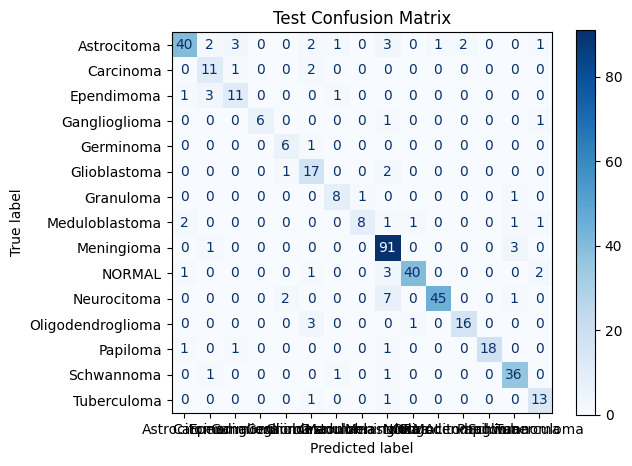

In [59]:
import os
import torch
import numpy as np
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ==== Config ====
DATA_DIR = Path("./dataset")
MODEL_SAVE_PATH = Path("./models_customcnn2/multiclass_model.pth")
IMG_SIZE = 224
BATCH_SIZE = 64
LR = 5e-4
EPOCHS = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Class Setup ====
class_names = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])
class_to_idx = {cls: i for i, cls in enumerate(class_names)}
num_classes = len(class_names)
print("Found classes:", class_names)

# ==== Dataset ====
class MulticlassDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for class_name in class_names:
            class_dir = root_dir / class_name
            for ext in ("*.jpg", "*.jpeg", "*.png"):
                for img_path in class_dir.glob(ext):
                    self.samples.append((img_path, class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

# ==== Load and Split Dataset ====
full_dataset = MulticlassDataset(DATA_DIR, transform=transform)
lengths = [int(0.7 * len(full_dataset)), int(0.2 * len(full_dataset))]
lengths.append(len(full_dataset) - sum(lengths))
train_set, val_set, test_set = random_split(full_dataset, lengths, generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# ==== Model Definition ====
model = SpeedCNN_v2(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ==== Train/Eval Functions ====
def train_epoch(model, loader):
    model.train()
    running_loss, correct = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    return running_loss / len(loader.dataset), correct / len(loader.dataset)

def eval_epoch(model, loader):
    model.eval()
    running_loss, correct = 0.0, 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            preds = out.argmax(1)
            probs = F.softmax(out, dim=1)
            running_loss += loss.item() * x.size(0)
            correct += (preds == y).sum().item()
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return {
        "loss": running_loss / len(loader.dataset),
        "acc": correct / len(loader.dataset),
        "precision": precision_score(all_labels, all_preds, average='macro', zero_division=0),
        "recall": recall_score(all_labels, all_preds, average='macro', zero_division=0),
        "f1": f1_score(all_labels, all_preds, average='macro', zero_division=0),
        "confusion_matrix": confusion_matrix(all_labels, all_preds),
        "labels": all_labels,
        "preds": all_preds,
        "probs": np.array(all_probs)
    }

# ==== Training Loop ====
best_acc = 0.0
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_metrics = eval_epoch(model, val_loader)
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f} | Val Acc={val_metrics['acc']:.4f}")

    if val_metrics["acc"] > best_acc:
        best_acc = val_metrics["acc"]
        torch.save(model.state_dict(), MODEL_SAVE_PATH)

# ==== Final Evaluation ====
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
test_metrics = eval_epoch(model, test_loader)
print("\nTest Performance:")
print(f"Accuracy: {test_metrics['acc']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")

# ==== Confusion Matrix Plot ====
ConfusionMatrixDisplay(test_metrics["confusion_matrix"], display_labels=class_names).plot(cmap='Blues')
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()


Predicted Class: Ganglioglioma


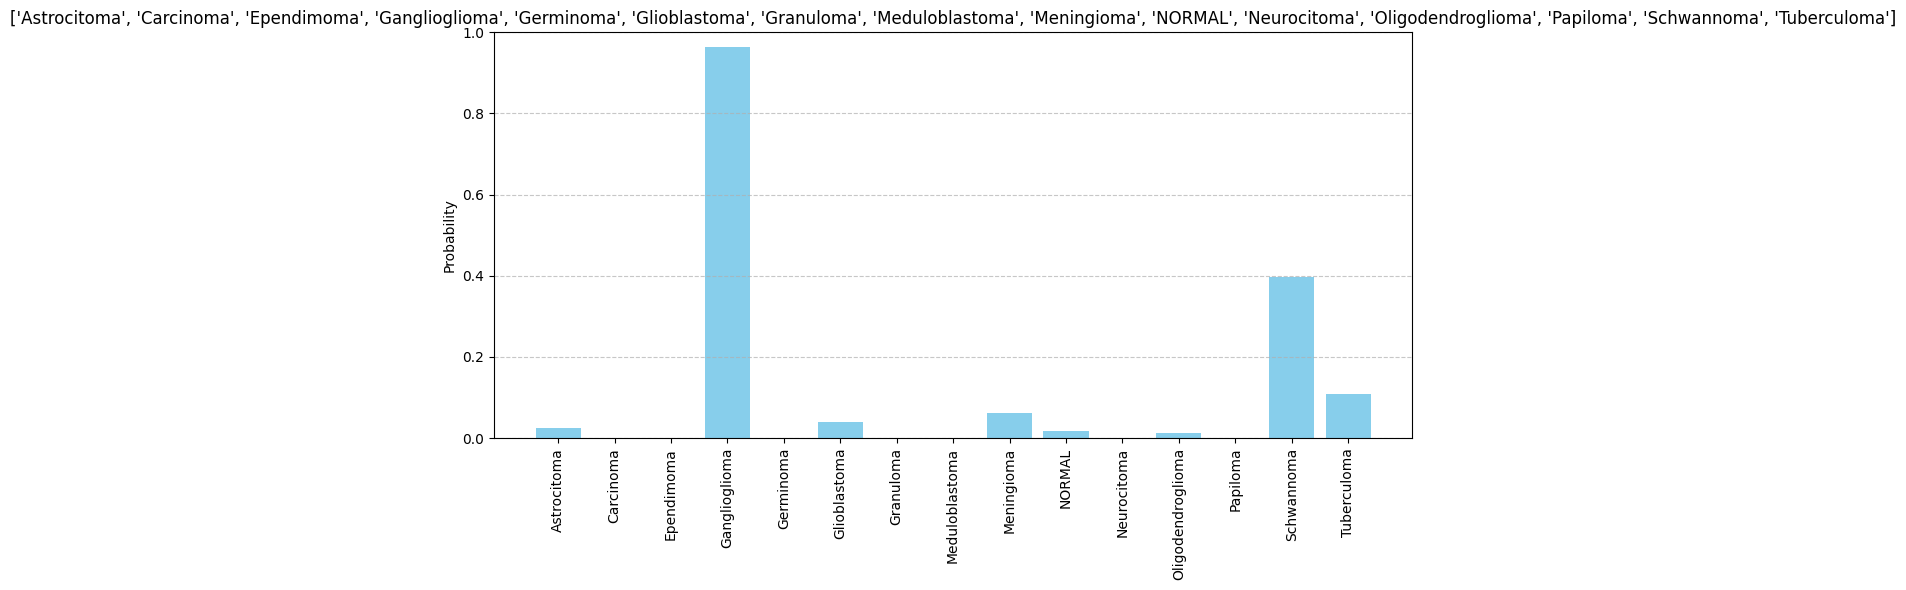

In [60]:
import matplotlib.pyplot as plt

def plot_class_probabilities(class_probabilities, title="Class Probabilities"):
    plt.figure(figsize=(10, 6))
    # Extract keys and values from the dictionary
    class_names = list(class_probabilities.keys())
    probabilities = list(class_probabilities.values())
    plt.bar(class_names, probabilities, color='skyblue')
    plt.ylabel("Probability")
    plt.ylim(0, 1)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
def predict_multiclass(image_path, transform, ensemble_models, class_names):
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)

    class_probs = {}
    for cls in class_names:
        model = ensemble_models[cls]
        model.eval()
        with torch.no_grad():
            output = model(img)
            prob = torch.sigmoid(output).item()
            class_probs[cls] = prob

    predicted_class = max(class_probs, key=class_probs.get)
    return predicted_class, class_probs
test_img = "dataset - Copy/Ganglioglioma T1/1.2.840.113619.2.80.3040119935.32584.1613839126.7_big_gallery.jpeg"
predicted_class, class_probabilities = predict_multiclass(test_img, transform, ensemble_models, class_names)

print("Predicted Class:", predicted_class)
plot_class_probabilities(class_probabilities, class_names)



In [66]:
class_names

['Astrocitoma',
 'Carcinoma',
 'Ependimoma',
 'Ganglioglioma',
 'Germinoma',
 'Glioblastoma',
 'Granuloma',
 'Meduloblastoma',
 'Meningioma',
 'NORMAL',
 'Neurocitoma',
 'Oligodendroglioma',
 'Papiloma',
 'Schwannoma',
 'Tuberculoma']

In [55]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        input_tensor = input_tensor.unsqueeze(0).to(device)
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output)

        output[:, class_idx].backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.squeeze(0)

        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        heatmap = torch.sum(activations, dim=0).cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap = heatmap / np.max(heatmap) if np.max(heatmap) != 0 else heatmap
        return heatmap

def overlay_heatmap(img, heatmap):
    import cv2

    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img = img.permute(1, 2, 0).cpu().numpy()
    img = np.uint8(255 * (img * np.array([0.229, 0.224, 0.225]) + 
                          np.array([0.485, 0.456, 0.406])))
    img = np.clip(img, 0, 255)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)
    return superimposed_img


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


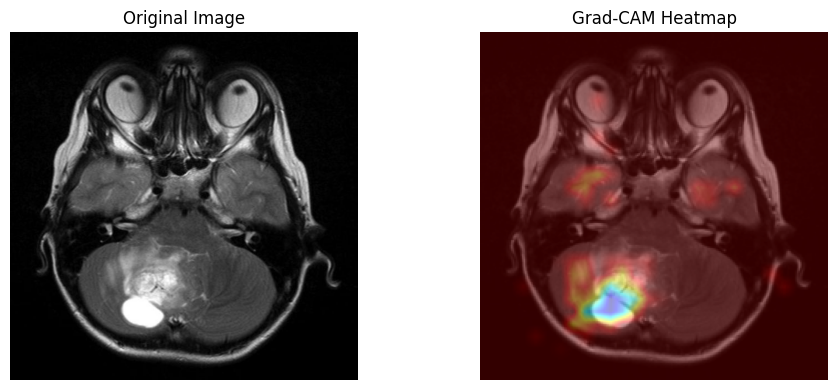

In [61]:

from matplotlib import pyplot as plt

# Load model and image
model_path = MODEL_SAVE_DIR / f"best_binary_{class_names[0]}.pth"
model = create_binary_model()
model.load_state_dict(torch.load(model_path, map_location=device))

# Hook to the last conv layer (update if you modify your model)
target_layer = model.blocks[-2]  # last DepthwiseSeparableConv

gradcam = GradCAM(model, target_layer)

# Load a test image from the dataset
img_path, label = ds.samples[4]
img_pil = Image.open(img_path).convert("RGB")
img_tensor = transform(img_pil)

# Generate heatmap
heatmap = gradcam.generate(img_tensor)
overlay = overlay_heatmap(img_tensor, heatmap)

# Display
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img_pil)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(overlay)
plt.axis("off")
plt.tight_layout()
plt.show()
